In [1]:
!date

Tue Jul  4 11:34:16 EDT 2023


In [2]:
pwd

'/mmfs1/data/aglinska/BC-ABCD-ADHD'

In [3]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import pickle
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.decomposition import PCA

from tqdm import tqdm

/data/aglinska/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [4]:
import ants

/data/aglinska/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/data/aglinska/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [5]:
def fit_rsa(rdm_data,rdm_model):
    return np.corrcoef(get_triu(rdm_data),get_triu(rdm_model))[0,1]
        
def make_RDM(inVec,data_scale='ratio',metric='euclidean'):
    vec = inVec
    vec = (vec - min(vec.flatten())) / (max(vec.flatten())-min(vec.flatten()))
    
    if np.ndim(inVec)==1: # must be at least 2D
        vec = np.vstack((vec,np.zeros(vec.shape))).transpose()
                   
    mat = squareform(pdist(vec,metric=metric).transpose())

    if data_scale=='ordinal':
        mat[mat!=0]=1 # Make into zeros and ones
        
    return mat

def get_triu(inMat):

    assert np.ndim(inMat)==2, 'not 2 dim, wtf'
    assert inMat.shape[0]==inMat.shape[1], 'not a square'

    n = inMat.shape[0]
    triu_vec = inMat[np.triu_indices(n=n,k=1)]
    
    return triu_vec

In [6]:
df = pd.read_csv('./df_rsa.csv')
df['bids_id'] = ['sub-'+val.replace('_','') for val in df['subjectkey'].values]
df

,Unnamed: 0,subjectkey,eventname,interview_age,sex,sexID,mri_info_deviceserialnumber,scannerID,IQ,sumSympt,bids_id
0,0,NDAR_INV0VXEC29A,baseline_year_1_arm_1,125,F,1,HASH5ac2b20b,1,19.0,17,sub-NDARINV0VXEC29A
1,1,NDAR_INVXWXUUU18,baseline_year_1_arm_1,109,M,2,HASH69f406fa,2,20.0,9,sub-NDARINVXWXUUU18
2,2,NDAR_INVZ4NNCTMH,baseline_year_1_arm_1,125,F,1,HASH1314a204,3,18.0,10,sub-NDARINVZ4NNCTMH
3,3,NDAR_INVKT7E0NA1,baseline_year_1_arm_1,131,M,2,HASH4b0b8b05,4,17.0,18,sub-NDARINVKT7E0NA1
4,4,NDAR_INV20CZ5PTX,baseline_year_1_arm_1,130,M,2,HASHdb2589d4,5,13.0,11,sub-NDARINV20CZ5PTX
...,...,...,...,...,...,...,...,...,...,...,...
5007,5007,NDAR_INV1EGW0J5N,baseline_year_1_arm_1,109,M,2,HASHb640a1b8,7,20.0,0,sub-NDARINV1EGW0J5N
5008,5008,NDAR_INV2F729N9A,baseline_year_1_arm_1,117,F,1,HASHc3bf3d9c,16,20.0,0,sub-NDARINV2F729N9A
5009,5009,NDAR_INVMAW066K7,baseline_year_1_arm_1,120,F,1,HASH96a0c182,10,21.0,0,sub-NDARINVMAW066K7
5010,5010,NDAR_INV5DJB8FFX,baseline_year_1_arm_1,114,F,1,HASH5ac2b20b,1,19.0,0,sub-NDARINV5DJB8FFX


In [7]:
## Get whole brain data
fn_temp = './Data/ABCD-anat/{bids_id}/ses-baselineYear1Arm1/anat/{bids_id}_ses-baselineYear1Arm1_run-01_T1w.nii'

In [8]:
vec_exists = [os.path.exists(fn_temp.format(bids_id=val)) for val in df['bids_id'].values]
df['anat_exists'] = vec_exists
np.array(vec_exists).mean()

0.9648842777334398

In [9]:
df = df.iloc[vec_exists]

In [10]:
#df = df.iloc[df['sumSympt'].values>0]

In [11]:
extract_data = False
if extract_data:
    for s in tqdm( range(len(df)) ):
        im = ants.image_read( fn_temp.format(bids_id=df['bids_id'].values[s]) ).resample_image(resample_params=(64,64,64), use_voxels=True, interp_type=4)
        np.save(file=os.path.join('./Data/mri_arrs_64',df['bids_id'].values[s]+'.npy'),arr=im.numpy())

In [12]:
#mri_col = [np.load(os.path.join('./Data/mri_arrs_64',df['bids_id'].values[s]+'.npy')) for s in range(10)]

In [13]:
n_subs = len(df)
n_subs

4836

In [14]:
mri_arr = np.zeros((n_subs,64*64*64))
mri_arr.shape

(4836, 262144)

In [27]:
mean_brain = mri_arr.mean(axis=0).reshape(64,64,64)

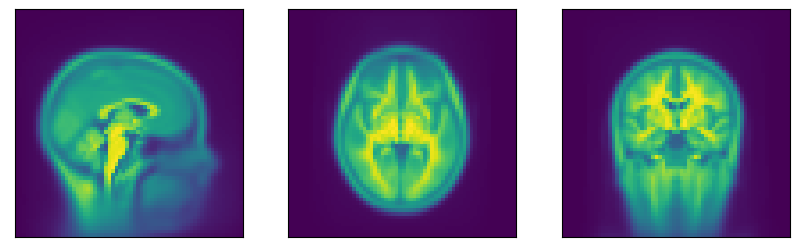

In [44]:
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(mean_brain[32,:,:])
plt.xticks([]);plt.yticks([]);

plt.subplot(1,3,2)
plt.imshow( np.rot90(mean_brain[:,32,:]) )
plt.xticks([]);plt.yticks([]);

plt.subplot(1,3,3)
plt.imshow( np.rot90(mean_brain[:,:,32],k=3) )
plt.xticks([]);plt.yticks([]);

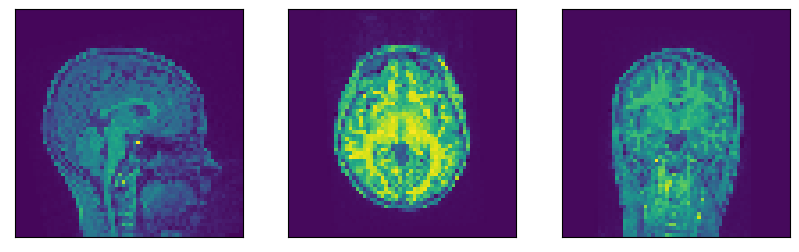

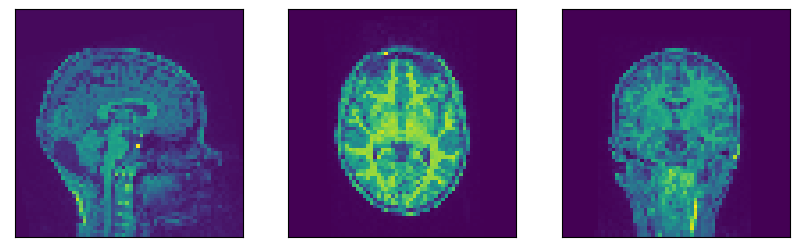

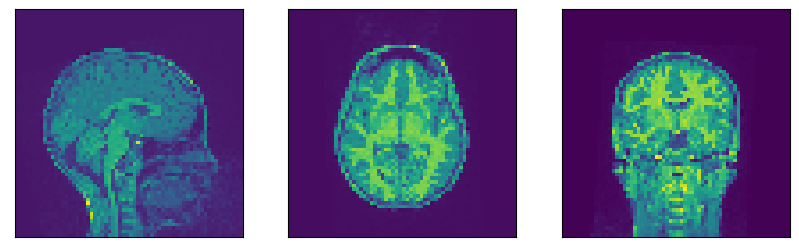

In [50]:
for s in np.random.randint(low=0,high=mri_arr.shape[0],size=3):
    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1)
    plt.imshow(mri_arr[s,:].reshape(64,64,64)[32,:,:])
    plt.xticks([]);plt.yticks([]);

    plt.subplot(1,3,2)
    plt.imshow( np.rot90(mri_arr[s,:].reshape(64,64,64)[:,32,:]) )
    plt.xticks([]);plt.yticks([]);

    plt.subplot(1,3,3)
    plt.imshow( np.rot90(mri_arr[s,:].reshape(64,64,64)[:,:,32],k=3) )
    plt.xticks([]);plt.yticks([]);

In [15]:
for s in tqdm(range(n_subs)):
    mri_arr[s,:] = np.load(os.path.join('./Data/mri_arrs_64',df['bids_id'].values[s]+'.npy')).flatten()

100%|██████████████████████████████████████| 4836/4836 [00:20<00:00, 238.20it/s]


In [16]:
pca_arr = PCA(n_components=10).fit_transform(mri_arr)

In [17]:
pca_arr.shape

(4836, 10)

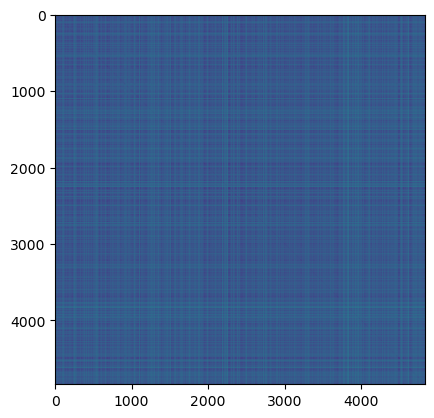

In [18]:
rdm_data = make_RDM(pca_arr,data_scale='ratio',metric='euclidean')
#rdm_data = make_RDM(pca_arr,data_scale='ratio',metric='correlation')
plt.imshow(rdm_data)

In [19]:
rdm_age_model = make_RDM(df['interview_age'].values,data_scale='ratio',metric='euclidean')
rdm_sex_model = make_RDM(df['sexID'].values,data_scale='ordinal')
rdm_scanner_model = make_RDM(df['scannerID'].values,data_scale='ordinal')
rdm_symp_model = make_RDM(df['sumSympt'].values,data_scale='ratio',metric='euclidean')

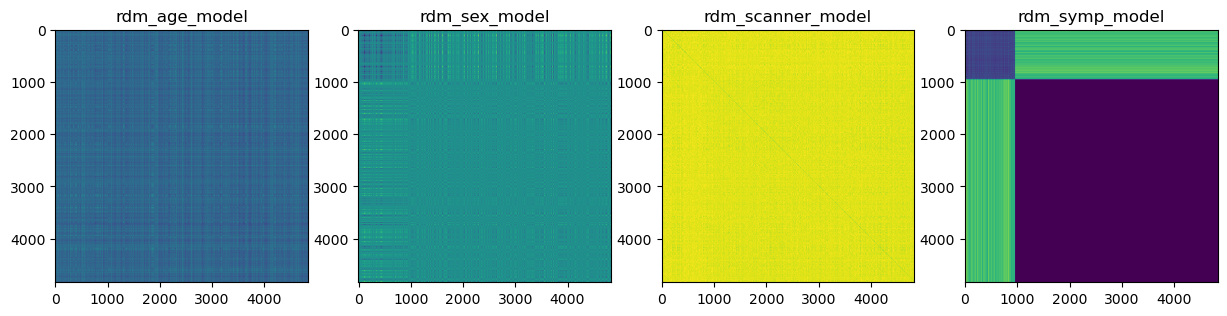

In [20]:
plt.figure(figsize=(15,5))
plt.subplot(1,4,1);plt.imshow(rdm_age_model);plt.title('rdm_age_model');
plt.subplot(1,4,2);plt.imshow(rdm_sex_model);plt.title('rdm_sex_model');
plt.subplot(1,4,3);plt.imshow(rdm_scanner_model);plt.title('rdm_scanner_model');
plt.subplot(1,4,4);plt.imshow(rdm_symp_model);plt.title('rdm_symp_model');

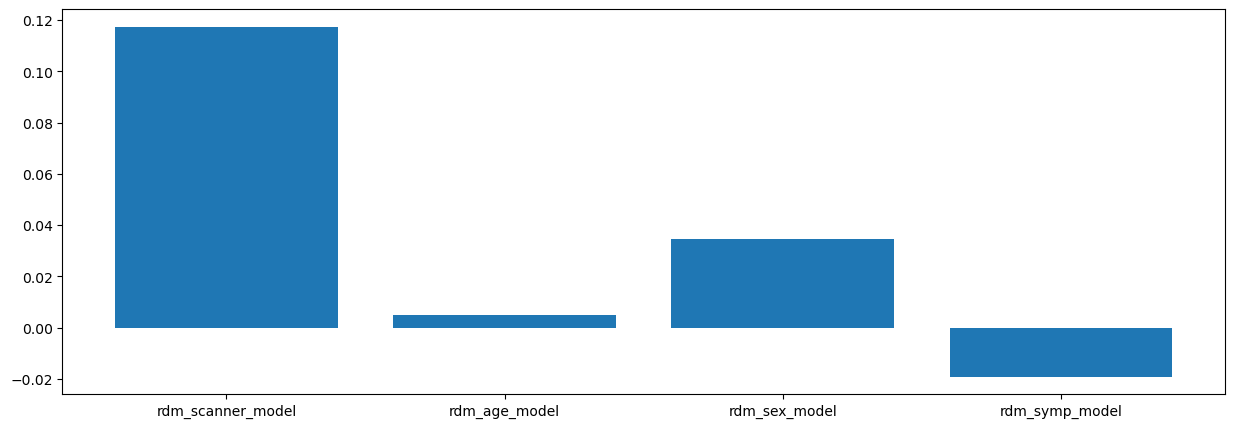

In [21]:
ys = [fit_rsa(rdm_data,model) for model in [rdm_scanner_model,rdm_age_model,rdm_sex_model,rdm_symp_model]]
xs = np.arange(len(ys))
lbls = ['rdm_scanner_model','rdm_age_model','rdm_sex_model','rdm_symp_model']

plt.figure(figsize=(15,5));
plt.bar(xs,ys);
plt.xticks(xs,labels=lbls);